In [1]:
import json
import os
import random

import cv2
from datasets import load_from_disk, concatenate_datasets
import evaluate
from matplotlib import pyplot as plt
import numpy as np
import torch
from torchvision import transforms as T
from transformers import VisionEncoderDecoderModel, AutoImageProcessor, AutoTokenizer, TimesformerForVideoClassification

In [2]:
image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [2]:
dataset = load_from_disk("dataset/processed/k600_16frames_10captions")
dataset.set_format(type="numpy")
dataset

DatasetDict({
    train: Dataset({
        features: ['video_id', 'pixel_values', 'labels'],
        num_rows: 1016
    })
    validation: Dataset({
        features: ['video_id', 'pixel_values', 'labels'],
        num_rows: 117
    })
})

In [3]:
print(dataset["train"][0]["pixel_values"].shape)
print(dataset["train"][0]["labels"].shape)
print(dataset["validation"][0]["pixel_values"].shape)
print(dataset["validation"][0]["labels"].shape)

(16, 3, 224, 224)
(10, 1024)
(8, 3, 224, 224)
(1024,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

A man demonstrates how to use a wrestling move and pins another man to a mat on the floor.
Two men are performing martial arts and one man throws the other to the floor and demonstrates a hold.
Two men wrestle on a mat with one man holding the other man down before letting him up.
A guy in blue shorts lifts another man, slams him to an athletic mat, and pins him.
A man lifts up another man, throws him on the floor, and gets on top of him.
in a jam two people are wrestling with each other and one of them wins
A man lift the other man and throws him down and sits on that man
Two men fight each other with one man taking the other to the ground.
Two men wrestle and one of them throws the other to the ground.
A practice of wrestling going on in front of class watching.


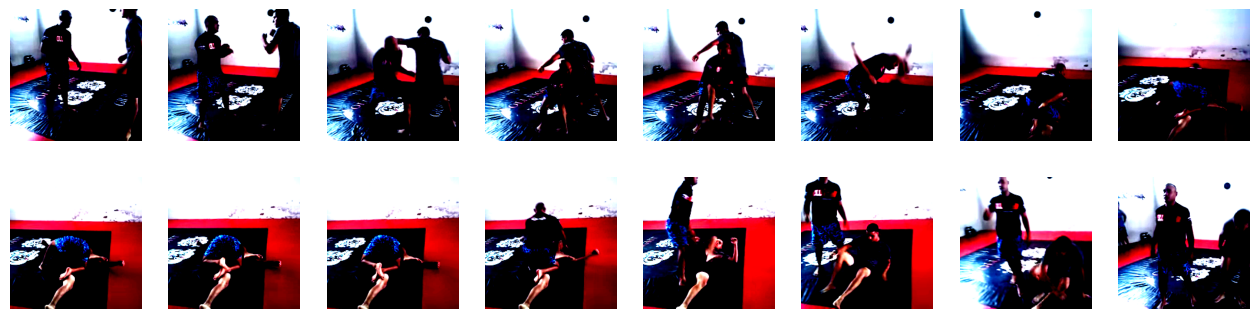

In [4]:
item = dataset["train"][420]
frames = item["pixel_values"]
labels = item["labels"]
captions = tokenizer.batch_decode(labels, skip_special_tokens=True)
for caption in captions:
    print(caption)

FRAMES_PER_VIDEO = 16
rows = 2
cols = FRAMES_PER_VIDEO // rows
fig = plt.figure(figsize=(16, 4))

for i in range(FRAMES_PER_VIDEO):
    frame = frames[i]
    frame = np.moveaxis(frame, 0, 2)
    
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(frame)
    plt.axis("off")

In [8]:
training_dir = "training/dropout"
label = None
lr = "5e-7"
with open(os.path.join(training_dir, lr, "val_output.json")) as json_file:
    captions = json.load(json_file)
    if label is None:
        label, predictions = random.choice(list(captions.items()))
        print("Label: %s\n" % label)
    else:
        predictions = captions[label]

    print("\033[0m Learning Rate: %s" % lr)
    print("\033[0m Predictions:")
    for i, pred in enumerate(predictions):
        if i == len(predictions) - 6:
            print("\033[91m %d: %s" % (i+1, pred))
        elif i == len(predictions) - 1:
            print("\033[94m %d: %s\n" % (i+1, pred))
        else:
            print("\033[0m %d: %s" % (i+1, pred))

Label: As 2 women are talking  and laughing off camera, the newborn infant is bundled up and is mean mugging the camera.

 Learning Rate: 5e-7
 Predictions:
 1: I'm not sure if I I I I I I I I I
 2: A woman walks past a sign that reads, "I am a woman."

A woman walks past a sign that reads, "I am a woman."

A woman walks past a sign that reads, "I am a woman."
 3: A man walks into a bar with a bottle of water in his hand.

A man walks into a bar with a bottle of water in his hand.
 4: A man walks into a store and asks a woman what she is doing.

A man walks into a store and asks a woman what she is doing.
 5: A man walks into a store and asks a woman what she is doing.

A man walks into a store and asks a woman what she is doing.
 6: A man walks in front of a group of people and asks them questions.

A man walks in front of a group of people.
 7: A man walks into a store and asks a woman what she is doing.
 8: A man is standing in front of a woman and a man is standing in front of him.

In [16]:
dataset = load_from_disk("dataset/processed/k600")
dataset

DatasetDict({
    train: Dataset({
        features: ['videoID', 'pixel_values', 'labels'],
        num_rows: 1016
    })
    validation: Dataset({
        features: ['videoID', 'pixel_values', 'labels'],
        num_rows: 117
    })
})

<BarContainer object of 30 artists>

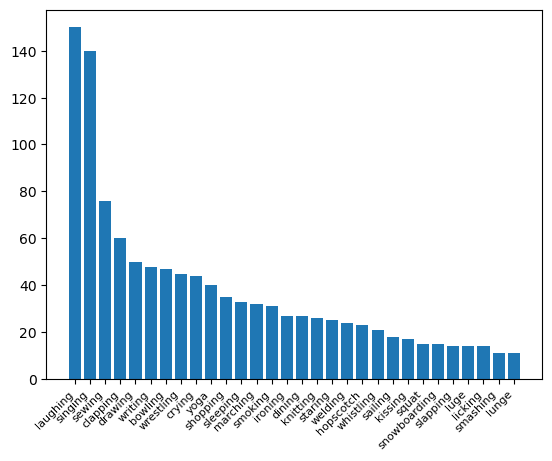

In [17]:
action_idxs = {'staring': {'train': (0, 22), 'val': (0, 3)}, 'laughing': {'train': (22, 158), 'val': (3, 17)}, 'singing': {'train': (158, 285), 'val': (17, 30)}, 'clapping': {'train': (285, 339), 'val': (30, 36)}, 'drawing': {'train': (339, 384), 'val': (36, 41)}, 'wrestling': {'train': (384, 424), 'val': (41, 46)}, 'dining': {'train': (424, 448), 'val': (46, 49)}, 'writing': {'train': (448, 491), 'val': (49, 54)}, 'bowling': {'train': (491, 533), 'val': (54, 59)}, 'squat': {'train': (533, 546), 'val': (59, 61)}, 'slapping': {'train': (546, 558), 'val': (61, 63)}, 'lunge': {'train': (558, 568), 'val': (63, 64)}, 'welding': {'train': (568, 589), 'val': (64, 67)}, 'luge': {'train': (589, 601), 'val': (67, 69)}, 'smashing': {'train': (601, 611), 'val': (69, 70)}, 'shopping': {'train': (611, 642), 'val': (70, 74)}, 'sailing': {'train': (642, 658), 'val': (74, 76)}, 'crying': {'train': (658, 698), 'val': (76, 80)}, 'yoga': {'train': (698, 734), 'val': (80, 84)}, 'sleeping': {'train': (734, 764), 'val': (84, 87)}, 'whistling': {'train': (764, 783), 'val': (87, 89)}, 'licking': {'train': (783, 795), 'val': (89, 91)}, 'knitting': {'train': (795, 818), 'val': (91, 94)}, 'sewing': {'train': (818, 887), 'val': (94, 101)}, 'smoking': {'train': (887, 915), 'val': (101, 104)}, 'snowboarding': {'train': (915, 928), 'val': (104, 106)}, 'marching': {'train': (928, 957), 'val': (106, 109)}, 'hopscotch': {'train': (957, 977), 'val': (109, 112)}, 'kissing': {'train': (977, 992), 'val': (112, 114)}, 'ironing': {'train': (992, 1016), 'val': (114, 117)}}

count_actions = []
for action, idxs in action_idxs.items():
    (train_lo, train_hi), (val_lo, val_hi) = idxs["train"], idxs["val"]
    count_actions.append((train_hi - train_lo + val_hi - val_lo, action))
count_actions.sort(reverse=True)

plt.xticks(rotation=45, ha="right", fontsize=8)
plt.bar([action for _, action in count_actions], [count for count, _ in count_actions])

In [18]:
action_idxs

{'staring': {'train': (0, 22), 'val': (0, 3)}, 'laughing': {'train': (22, 158), 'val': (3, 17)}, 'singing': {'train': (158, 285), 'val': (17, 30)}, 'clapping': {'train': (285, 339), 'val': (30, 36)}, 'drawing': {'train': (339, 384), 'val': (36, 41)}, 'wrestling': {'train': (384, 424), 'val': (41, 46)}, 'dining': {'train': (424, 448), 'val': (46, 49)}, 'writing': {'train': (448, 491), 'val': (49, 54)}, 'bowling': {'train': (491, 533), 'val': (54, 59)}, 'squat': {'train': (533, 546), 'val': (59, 61)}, 'slapping': {'train': (546, 558), 'val': (61, 63)}, 'lunge': {'train': (558, 568), 'val': (63, 64)}, 'welding': {'train': (568, 589), 'val': (64, 67)}, 'luge': {'train': (589, 601), 'val': (67, 69)}, 'smashing': {'train': (601, 611), 'val': (69, 70)}, 'shopping': {'train': (611, 642), 'val': (70, 74)}, 'sailing': {'train': (642, 658), 'val': (74, 76)}, 'crying': {'train': (658, 698), 'val': (76, 80)}, 'yoga': {'train': (698, 734), 'val': (80, 84)}, 'sleeping': {'train': (734, 764), 'val': (

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: A winter sports venue with a luge run and a red sled coming down the run.


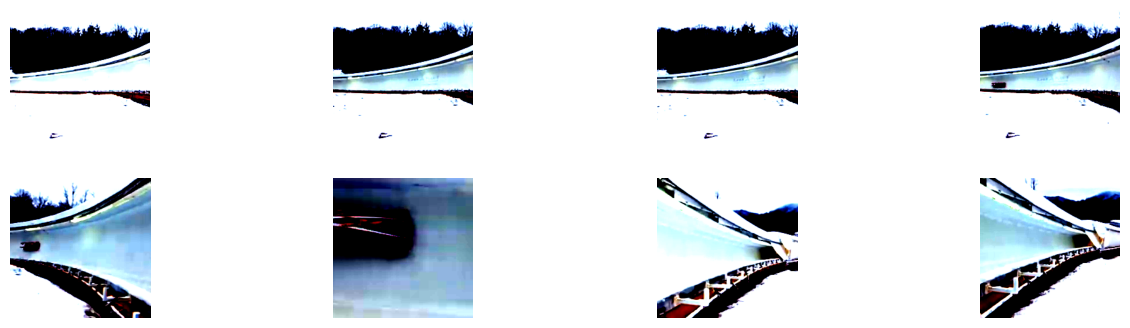

In [21]:
dataset.set_format(type="numpy")
data_train, data_val = dataset["train"], dataset["validation"]

data = data_train[589]
frames = data["pixel_values"]
caption = data["labels"]

caption = tokenizer.decode(caption, skip_special_tokens=True)
print("Label: %s" % caption)

FRAMES_PER_VIDEO = 8
rows = 2
cols = FRAMES_PER_VIDEO // rows
fig = plt.figure(figsize=(16, 4))

for i in range(FRAMES_PER_VIDEO):
    frame = frames[i]
    frame = np.moveaxis(frame, 0, 2)
    
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(frame)
    plt.axis("off")

In [25]:
dataset = load_from_disk("dataset/processed_frames_8")
dataset.set_format(type="numpy")
data_train = dataset["train"]
data_train

In [37]:
dataset = load_from_disk("dataset/test")

transforms = T.Compose([
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomPerspective(),
    T.RandomRotation(15),
    T.RandomAdjustSharpness(2),
    T.RandomAutocontrast(),
])

def transform(batch):
    for i, pixel_values in enumerate(batch["pixel_values"]):
        pixel_values = torch.FloatTensor(pixel_values)
        pixel_values = pixel_values[::2]
        
        for j, frame in enumerate(pixel_values):
            frame = frame.permute(2, 0, 1)
            frame = transforms(frame)
            frame = frame.permute(1, 2, 0)
            pixel_values[j] = frame
            
        pixel_values = image_processor(list(pixel_values), return_tensors="pt").pixel_values
        batch["pixel_values"][i] = pixel_values
        
    batch["pixel_values"] = torch.cat(batch["pixel_values"])
    batch["labels"] = torch.LongTensor(batch["labels"])
    return batch

dataset["train"].set_transform(transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: a man was playing some musical instrument on the center of road many people walking by his side and some sit on the chairs with table under the hut  and have their food
Model Ouput: A man is playing a musical instrument in front of a crowd of people, while people are walking by.


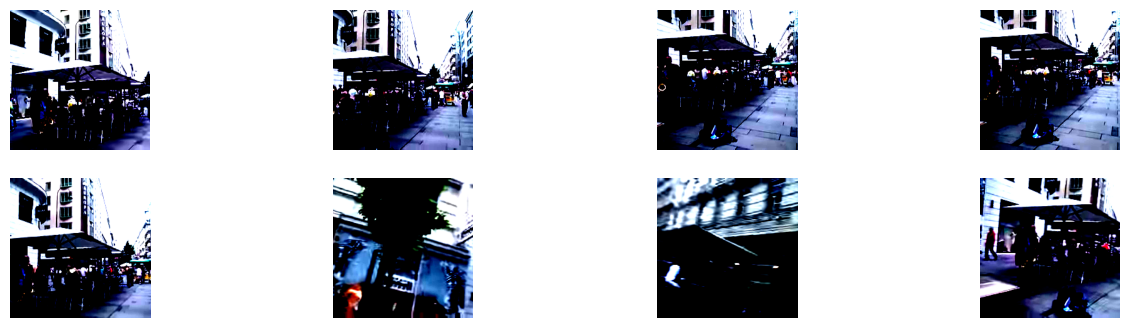

In [15]:
# training data and model output

idx = random.randint(0, len(data_train) - 1)
data = data_train[idx]
frames = data["pixel_values"]
caption = data["labels"]

caption = tokenizer.decode(caption, skip_special_tokens=True)
print("Label: %s" % caption)

FRAMES_PER_VIDEO = 8
rows = 2
cols = FRAMES_PER_VIDEO // rows
fig = plt.figure(figsize=(16, 4))

for i in range(FRAMES_PER_VIDEO):
    frame = frames[i]
    frame = np.moveaxis(frame, 0, 2)
    
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(frame)
    plt.axis("off")
    
generated_ids = model.generate(torch.from_numpy(frames).unsqueeze(0), max_length=30, num_beams=2, early_stopping=True)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Model Ouput: %s" % generated_text)

Video ID: W1Yjfexk8l8_000444_000454

Captions:
['A man eats something and then drinks some wine in his home.', 'A man moved around his tongue in his mouth and then drank wine', 'A man chews something in his mouth before taking a sip of wine.', 'A man tastes some food before taking a taste of red wine.', 'A guy sitting down and trying a glass of wine at what seems to be his house.', 'A man chews and then takes a small sip of red wine.', 'A man is sitting and swishing wine around in his mouth, then takes a sip of wine.', 'A man takes a big sip of red wine from a wine glass.', 'A man says he will try some wine and then proceeds to do it.', 'A man is sitting by himself while he tastes some red wine out of a glass.']

Longest Caption:
A guy sitting down and trying a glass of wine at what seems to be his house.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


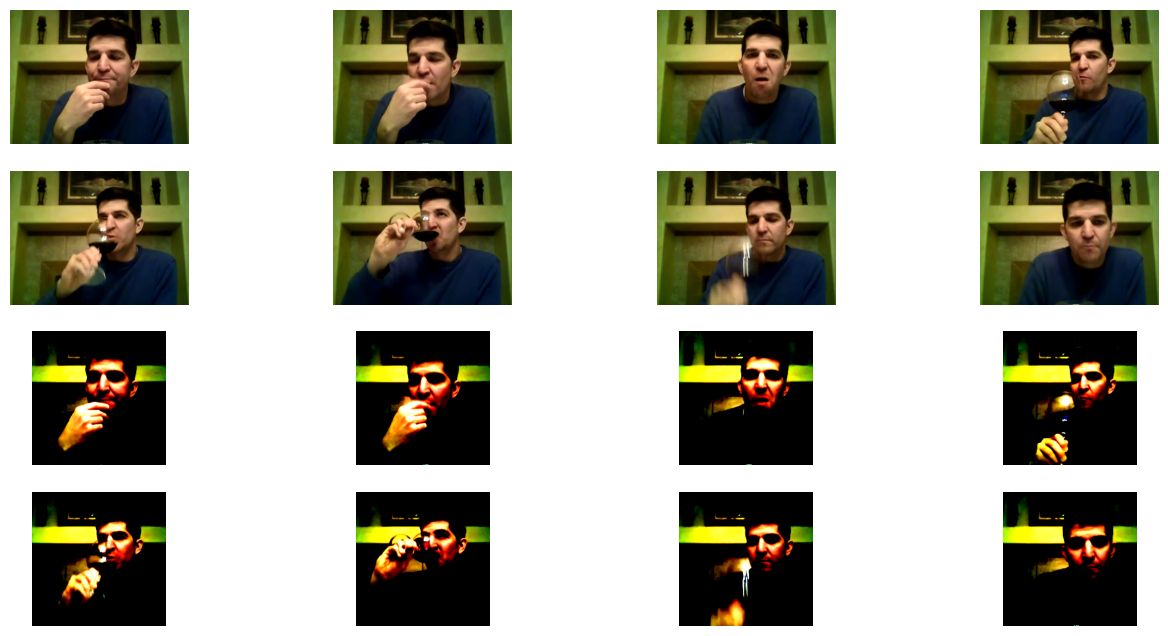

In [20]:
# visualize video frame sampling and image processing

FRAMES_PER_VIDEO = 8
rows = 4
cols = 4
fig = plt.figure(figsize=(16, 8))

with open("dataset/vatex_train_captions.json") as file:
    data = json.load(file)
    idx = random.randint(0, len(data) - 1)
    item = data[idx]
    
    video_id = item["videoID"]
    captions = item["enCap"]
    
    print("Video ID: %s" % video_id)
    print("\nCaptions:")
    print(captions)
    
    # longest caption
    max_len = -np.inf
    max_cap = None
    for caption in captions:
        length = len(caption.split(" "))
        if length > max_len:
            max_len = length
            max_cap = caption
    print("\nLongest Caption:")
    print(max_cap)
    
    videos_path = "dataset/videos"
    video_path = os.path.join(videos_path, "%s.mp4" % video_id)
    if not os.path.isfile(video_path):
        video_path = os.path.join(videos_path, "%s.webm" % video_id)
    video = cv2.VideoCapture(video_path)
        
    # count number of frames
    frame_count = 0
    while True:
        ret = video.grab()
        if not ret:
            break
        frame_count += 1
    video.set(cv2.CAP_PROP_POS_FRAMES, 0)
        
    # fixed frame sampling
    indices = np.linspace(0, frame_count, num=FRAMES_PER_VIDEO, endpoint=False).astype(np.int64)
    # random frame sampling
    #indices = np.sort(np.random.uniform(low=0, high=frame_count, size=self.num_frames).astype(np.int64))
    
    # get frames
    frames = []
    frame_count, frame_idx = 0, 0
    while frame_idx < len(indices):
        if frame_count == indices[frame_idx]:
            _, frame = video.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
            frame_idx += 1
            
            fig.add_subplot(rows, cols, frame_idx)
            plt.imshow(frame)
            plt.axis("off")
        else:
            video.grab()
        frame_count += 1
    video.release()
    
    # processed frames
    pixel_values = image_processor(frames, return_tensors="np").pixel_values[0]
    pixel_values = np.moveaxis(pixel_values, 1, 3)
    for i, frame in enumerate(pixel_values):
        fig.add_subplot(rows, cols, i + 8 + 1)
        plt.imshow(frame)
        plt.axis("off")

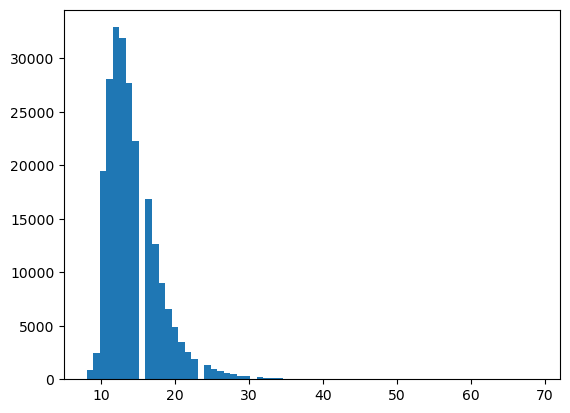

Mean:
[14.23141759 14.22067429 14.1939034  14.24962879 14.24181151 14.2024631
 14.21862171 14.23556643 14.19761551 14.23595947]
Min:
[8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
Max:
[65. 55. 52. 51. 51. 64. 69. 59. 53. 52.]


In [23]:
# caption length distribution

with open("dataset/vatex_train_captions.json") as file:
    lengths = []
    means = np.zeros(10)
    mins = np.ones(10) * np.inf
    maxs = np.zeros(10)
    
    data = json.load(file)
    for video in data:
        for i, caption in enumerate(video["enCap"]):
            length = len(caption.split(" "))
            lengths.append(length)
            means[i] += length
            mins[i] = min(mins[i], length)
            maxs[i] = max(maxs[i], length)
    
    plt.hist(lengths, bins=int(maxs.max()))
    plt.show()
    
    means /= len(data)
    print("Mean:")
    print(means)
    print("Min:")
    print(mins)
    print("Max:")
    print(maxs)

In [16]:
# average rouge scores among all 10 captions

metric = evaluate.load("rouge")
rouge = np.zeros(4)
count = 0

with open("dataset/vatex_train_captions.json") as file:
    json_data = json.load(file)
    idx = random.randint(0, len(json_data) - 1)
    data = json_data[idx]
    
    captions = data["enCap"]
    print(captions)
    for i, cap1 in enumerate(captions):
        for j in range(i + 1, len(captions)):
            cap2 = captions[j]
            result = metric.compute(predictions=[cap1], references=[cap2])
            rouge += np.fromiter(result.values(), dtype=float)
            count += 1

print(rouge / count)

['A person is holding a rubrics cube and turning it.', 'Some one is spelling three letter words while turning a rubicks cube.', 'A boy spins a rubix cube around while explaining what he is doing.', "Someone manipulates a Rubic's cube while stating a series of letters.", "A person shows how to solve a Rubix cube using a the F, R, U, F', U', R' system.", 'A young man manipulates a rubix cube while reciting letters.', "A teenage boy demonstrates how to apply the caller and Rubik's cube.", 'A person is talking and trying to solve the Rubik cube.', 'A boy is demonstrating how to solve a rubix cube.', 'a person interacts with a cube that they have and try to figure it out']
[0.31179975 0.05699192 0.26847855 0.26847855]
